# Flow of a Darcy fluid through a lens of low permeability

problem specification
$$
\begin{cases}
\Omega = [-L_x/2, L_x/2] \times [-L_y/2, L_y/2] \\
\mathsf{K}=\begin{cases}
\kappa\mathsf{I} & (x/a)^2 + (y/b)^2 < 1 \\
\mathsf{I} & \text{otherwise} 
\end{cases} & \text{lens of low permeability}  \\
\mu = 1 \\
u_{\text{E}}(x,y=\pm L_y/2) = 0 & \text{no-penetration on upper and lower boundaries} \\
p_{\text{N}}(x=-L_x/2,y) = p_{\text{in}} & \text{pressure-driven flow from left to right} \\
p_{\text{N}}(x=L_x/2,y) = 0
\end{cases}
$$

In [1]:
from lucifex.mesh import rectangle_mesh, mesh_boundary
from lucifex.fem import Function, Constant
from lucifex.solver import bvp, BoundaryConditions, OptionsPETSc
from lucifex.utils import finite_element_function_components
from lucifex.viz import plot_colormap, plot_streamlines, plot_quiver
from lucifex.io import write, get_ipynb_file_name
from lucifex.pde.darcy import darcy_incompressible


Lx = 2.0
Ly = 1.0
mesh = rectangle_mesh((-Lx/2 , Lx/2), (-Ly/2, Ly/2), 200, 200, cell='right')
boundary = mesh_boundary(
    mesh, 
    {
        "left": lambda x: x[0] + Lx/2,
        "right": lambda x: x[0] - Lx/2,
        "lower": lambda x: x[1] + Ly/2,
        "upper": lambda x: x[1] - Ly/2,
    },
)

kappa = 0.05
a, b = (0.2 * Lx, 0.2 * Ly)
k = Function(
    (mesh, 'DP', 0), 
    lambda x: 1 + (kappa - 1) * ((x[0] / a)**2 + (x[1] / b)**2 < 1), 
    name='k',
)
mu = Constant(mesh, 1.0, 'mu')

u_deg = 1
u_elem = ('BDM', u_deg)
p_elem = ('DP', u_deg - 1)
u_p_elem = [u_elem, p_elem]
up = Function((mesh, u_p_elem), name="up")

u_bcs = BoundaryConditions(
    ('essential', boundary['upper', 'lower'], (0.0, 0.0), 0),
)
p_in = 1.0
p_bcs = BoundaryConditions(
    ('natural', boundary['left'], p_in, 1),
    ('natural', boundary['right'], 0.0, 1),
)

petsc = OptionsPETSc(pc_type='lu')
petsc['pc_factor_mat_solver_type'] = 'mumps'
up_solver = bvp(darcy_incompressible, u_bcs, petsc)(up, k, mu, p_bcs=p_bcs)
up_solver.solve()

u, p = up.split(('u', 'p'), collapse=True)
ux, uy = finite_element_function_components(('P', 1), u, names=('ux', 'uy'))

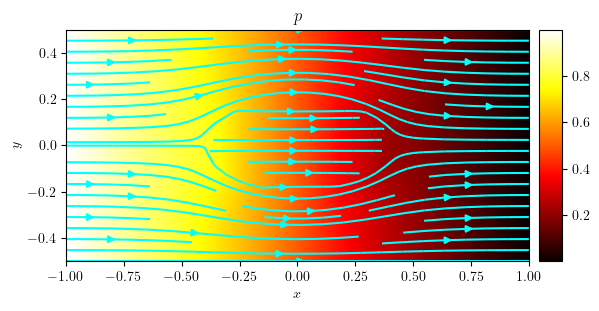

In [2]:
fig, ax = plot_colormap(p, title='$p$', x_label='$x$', y_label='$y$')
plot_streamlines(fig, ax, (ux, uy), density=0.75, color='cyan')
write(fig, f'{get_ipynb_file_name()}_p', './figures', file_ext=['pdf', 'png'], close=False, pickle=False)

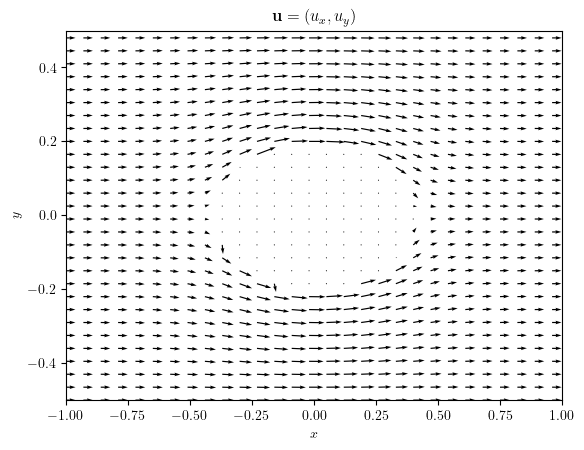

In [3]:
plot_quiver((ux, uy), title="$\\textbf{u}=(u_x, u_y)$", x_label='$x$', y_label='$y$')
write(fig, f'{get_ipynb_file_name()}_u', './figures', file_ext=['pdf', 'png'], close=False, pickle=False)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': '$K$'}, xlabel='$x$', ylabel='$y$'>)

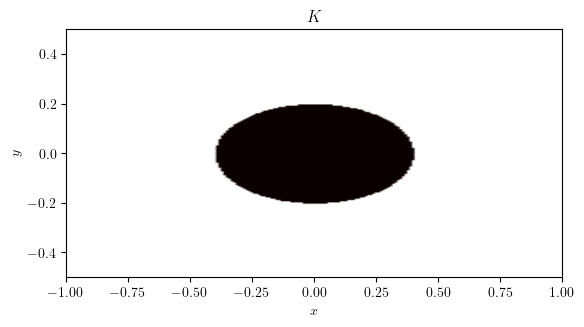

In [4]:
plot_colormap(k, title='$K$', colorbar=False)